# Milestone One: NFL Video Review Analysis Code

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import (
    LassoCV,
    RidgeCV,
    ElasticNetCV,
    LogisticRegression,
    LinearRegression
)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.cross_decomposition import PLSRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv("video_review.csv")
df_clean = df.dropna().copy()
df_clean = df_clean.drop(index=33)
df_clean['Friendly_Fire'] = df_clean['Friendly_Fire'].map({'Yes': 1, 'No': 0})

X = df_clean[['Player_Activity_Derived', 'Turnover_Related', 'Primary_Impact_Type', 'Primary_Partner_Activity_Derived']]
y = df_clean['Friendly_Fire']

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first'), X.columns)
])


In [48]:
df_clean
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)


## Week 1 – Polynomial and Interaction Terms

In [49]:
poly_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
    ('model', LinearRegression())
])
poly_pipeline.fit(X_train, y_train)
poly_score = poly_pipeline.score(X_test, y_test)
print(poly_score)


0.9742857147192465


## Week 2 – Regularized Regression

In [50]:

lasso_model = Pipeline([('preprocessor', preprocessor), ('model', LassoCV(cv=5, random_state=42))])
lasso_model.fit(X_train, y_train)
print("Lasso Accuracy:", accuracy_score(y_test, (lasso_model.predict(X_test) > 0.5).astype(int)))


Lasso Accuracy: 1.0


In [51]:

ridge_model = Pipeline([('preprocessor', preprocessor), ('model', RidgeCV(alphas=np.logspace(-3, 3, 50), cv=5))])
ridge_model.fit(X_train, y_train)
print("Ridge Accuracy:", accuracy_score(y_test, (ridge_model.predict(X_test) > 0.5).astype(int)))


Ridge Accuracy: 1.0


In [52]:

elastic_model = Pipeline([('preprocessor', preprocessor), ('model', ElasticNetCV(l1_ratio=[.1, .5, .9], cv=5, random_state=42))])
elastic_model.fit(X_train, y_train)
print("ElasticNet Accuracy:", accuracy_score(y_test, (elastic_model.predict(X_test) > 0.5).astype(int)))


ElasticNet Accuracy: 1.0


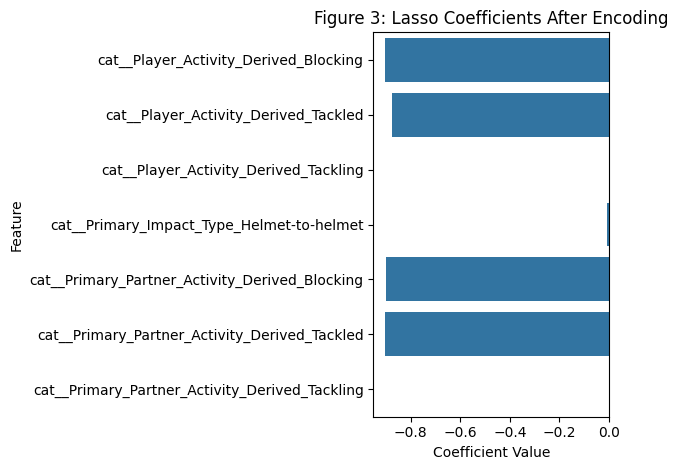

In [67]:
lasso_coefs = lasso_model.named_steps['model'].coef_
sns.barplot(x=lasso_coefs, y=feature_names)
plt.title("Figure 3: Lasso Coefficients After Encoding")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.tight_layout()


In [1]:
sns.countplot(data=df_clean, y='Player_Activity_Derived', hue='Friendly_Fire')
plt.title("Figure 4: Distribution of Player Activities by Friendly Fire")
plt.xlabel("Count")
plt.ylabel("Player Activity")
plt.tight_layout()


NameError: name 'sns' is not defined

## Week 3 – Feature Selection (PCR/PLS/Stepwise)

In [57]:
X_encoded = preprocessor.fit_transform(X)

# Split encoded data
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(
    X_encoded, y, stratify=y, random_state=42
)

### --- Principal Component Regression (PCR) using Truncated SVD ---
svd = TruncatedSVD(n_components=5)
X_train_svd = svd.fit_transform(X_train_pca)
X_test_svd = svd.transform(X_test_pca)

pcr_model = LinearRegression()
pcr_model.fit(X_train_svd, y_train_pca)
pcr_r2 = pcr_model.score(X_test_svd, y_test_pca)
print("PCR (Truncated SVD) R²:", round(pcr_r2, 4))


PCR (Truncated SVD) R²: -0.8116


In [58]:
### --- Partial Least Squares Regression (PLSR) ---
plsr_model = PLSRegression(n_components=2)
plsr_model.fit(X_train_pca.toarray(), y_train_pca)
plsr_r2 = plsr_model.score(X_test_pca.toarray(), y_test_pca)
print("PLSR R²:", round(plsr_r2, 4))


PLSR R²: 0.8578


In [61]:
stepwise_model = Pipeline([
    ('preprocessor', preprocessor),
    ('sfs', SequentialFeatureSelector(LinearRegression(), direction='forward')),
    ('model', LinearRegression())
])
stepwise_model.fit(X_train, y_train)
stepwise_r2 = stepwise_model.score(X_test, y_test)
print("Stepwise R² (Test Set):", round(stepwise_r2, 4))


Stepwise R² (Test Set): 0.9544


## Week 4 – Logistic Regression

In [ ]:

from sklearn.linear_model import LogisticRegression
log_model = Pipeline([('preprocessor', preprocessor), ('model', LogisticRegression())])
log_model.fit(X_train, y_train)
print("Logistic Regression Accuracy:", accuracy_score(y_test, log_model.predict(X_test)))


Logistic Regression Accuracy: 0.7777777777777778


## Week 5 – Support Vector Machine

In [ ]:

from sklearn.svm import SVC
svm_model = Pipeline([('preprocessor', preprocessor), ('model', SVC(kernel='linear', C=1))])
svm_model.fit(X_train, y_train)
print("SVM Accuracy:", accuracy_score(y_test, svm_model.predict(X_test)))


SVM Accuracy: 1.0


## Week 6 – Decision Tree and Random Forest

In [70]:

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

tree_model = Pipeline([('preprocessor', preprocessor), ('model', DecisionTreeClassifier(max_depth=3, random_state=42))])
tree_model.fit(X_train, y_train)
tree_preds = tree_model.predict(X_test)
print("Decision Tree Report:\n", classification_report(y_test, tree_preds))


Decision Tree Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         2

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9



In [71]:
rf_model = Pipeline([('preprocessor', preprocessor), ('model', RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42))])
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)
print("Random Forest Report:\n", classification_report(y_test, rf_preds))


Random Forest Report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       1.00      0.50      0.67         2

    accuracy                           0.89         9
   macro avg       0.94      0.75      0.80         9
weighted avg       0.90      0.89      0.87         9



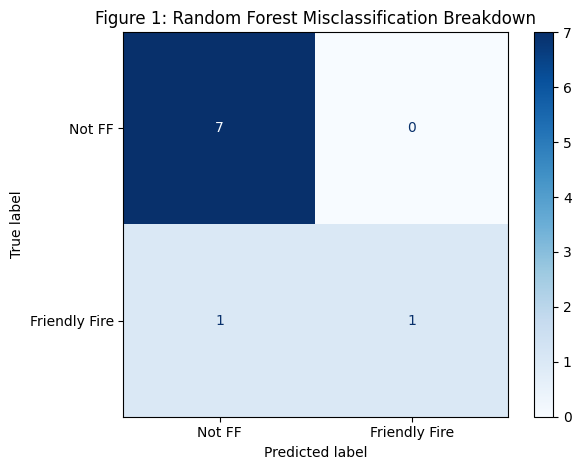

In [72]:
from sklearn.metrics import ConfusionMatrixDisplay
fig1, ax1 = plt.subplots()
ConfusionMatrixDisplay.from_predictions(y_test, rf_preds, ax=ax1, display_labels=['Not FF', 'Friendly Fire'], cmap='Blues')
ax1.set_title("Figure 1: Random Forest Misclassification Breakdown")
plt.tight_layout()


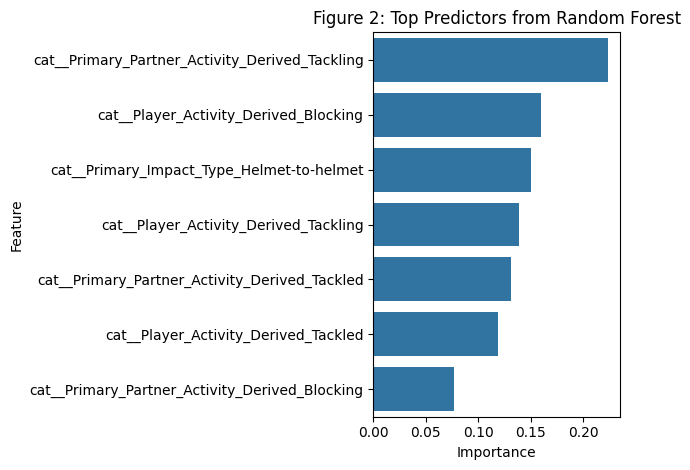

In [73]:
importances = rf_model.named_steps['model'].feature_importances_
feature_names = rf_model.named_steps['preprocessor'].get_feature_names_out()
indices = np.argsort(importances)[::-1]

sns.barplot(x=importances[indices][:10], y=feature_names[indices][:10])
plt.title("Figure 2: Top Predictors from Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
